# APC en utilisant `sklearn` (decomposition & preprocessing)

Variance expliquée par chaque composante : [0.39445939 0.2002698 ]
Composantes de l'ACP :
 [[ 0.09479093  0.46780033  0.59875711  0.47126353  0.43769639]
 [ 0.97793906 -0.20618023  0.01766139  0.01023727 -0.02661185]]


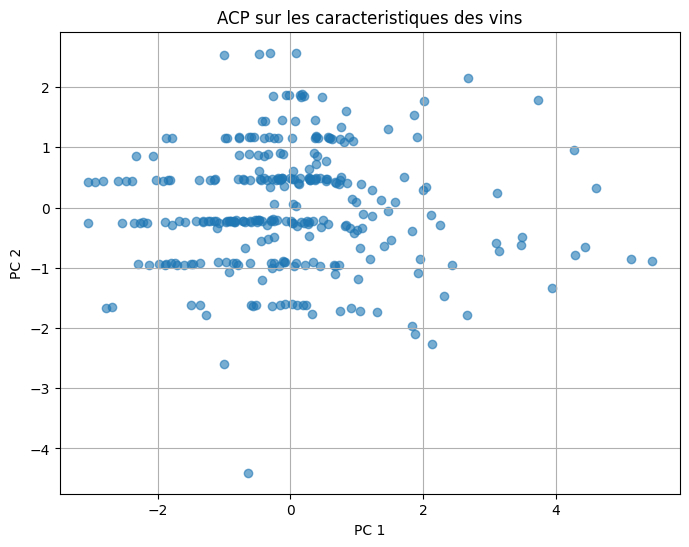

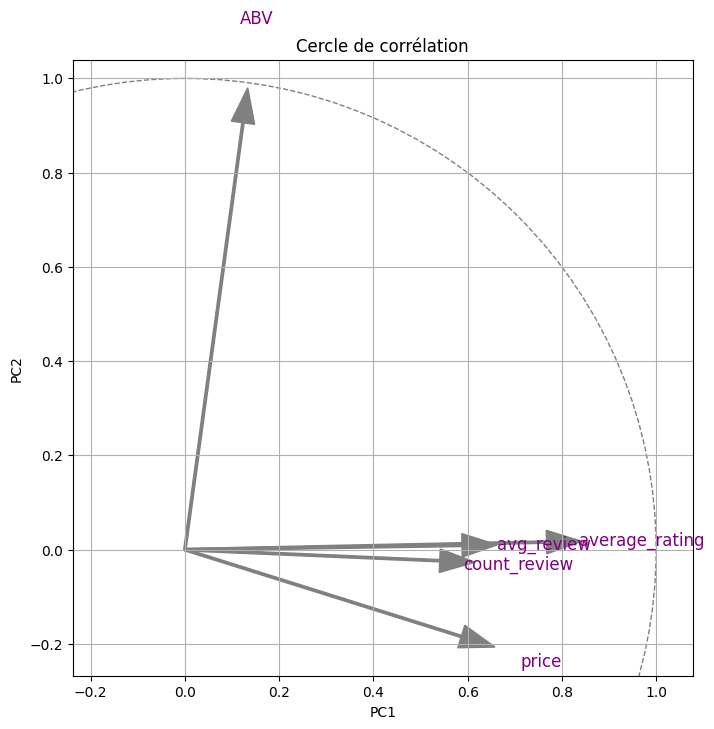

In [8]:
import os
from dotenv import load_dotenv
load_dotenv()
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def get_connection():
    return mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME")
    )
conn = get_connection()
cursor = conn.cursor()


# -- On fait toutes les requêtes et on les place dans des dataframes pour les anlyser avec panda
query_reviews = "SELECT * FROM all_reviews LIMIT 2000;"
cursor.execute(query_reviews)
reviews_data = cursor.fetchall()
reviews_columns = cursor.column_names
reviews_df = pd.DataFrame(reviews_data, columns=reviews_columns)

query_descriptifs = "SELECT * FROM descriptifs LIMIT 2000;"
cursor.execute(query_descriptifs)
descriptifs_data = cursor.fetchall()
descriptifs_columns = cursor.column_names
descriptifs_df = pd.DataFrame(descriptifs_data, columns=descriptifs_columns)

query_scrap = "SELECT * FROM scrap LIMIT 2000;"
cursor.execute(query_scrap)
scrap_data = cursor.fetchall()
scrap_columns = cursor.column_names
scrap_df = pd.DataFrame(scrap_data, columns=scrap_columns)
cursor.close()
conn.close()
# --------------------------------------------


reviews_agg = reviews_df.groupby('WineID').agg({'Rating': ['mean', 'count']})
reviews_agg.columns = ['avg_review', 'count_review']
reviews_agg.reset_index(inplace=True)

# Erreur de types, j'ai tout converti en string flemme
descriptifs_df['idwine'] = descriptifs_df['idwine'].astype('str')
scrap_df['idwine'] = scrap_df['idwine'].astype('str')
reviews_agg['WineID'] = reviews_agg['WineID'].astype('str')


# Fusion des dataframes sur idwine
df = pd.merge(descriptifs_df, scrap_df, on='idwine', how='inner')
df = pd.merge(df, reviews_agg, left_on='idwine', right_on='WineID', how='left')

features = ['ABV', 'price', 'average_rating', 'avg_review', 'count_review']
df_numeric = df[features].dropna()
df_numeric = df_numeric.astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# ACP (avec 2 composantes principales)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)
print("Composantes de l'ACP :\n", pca.components_)

# Premier graphe (nuage de points)
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("ACP sur les caracteristiques des vins")
plt.grid(True)
plt.show()

# -- Cercle de correlation --
"""
Loadings : corrélation entre les variables et les composantes
Corrélation :
loading = coefficient * sqrt(eigenvalue)
"""
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(8, 8))
ax = plt.gca()

circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              color='grey', width=0.005, head_width=0.05, length_includes_head=True)
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature,
             color='purple', ha='center', va='center', fontsize=12)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cercle de corrélation")
plt.grid(True)
plt.axis('equal')
plt.show()

# Sans passer par `sklearn` (decomposition & preprocessing)

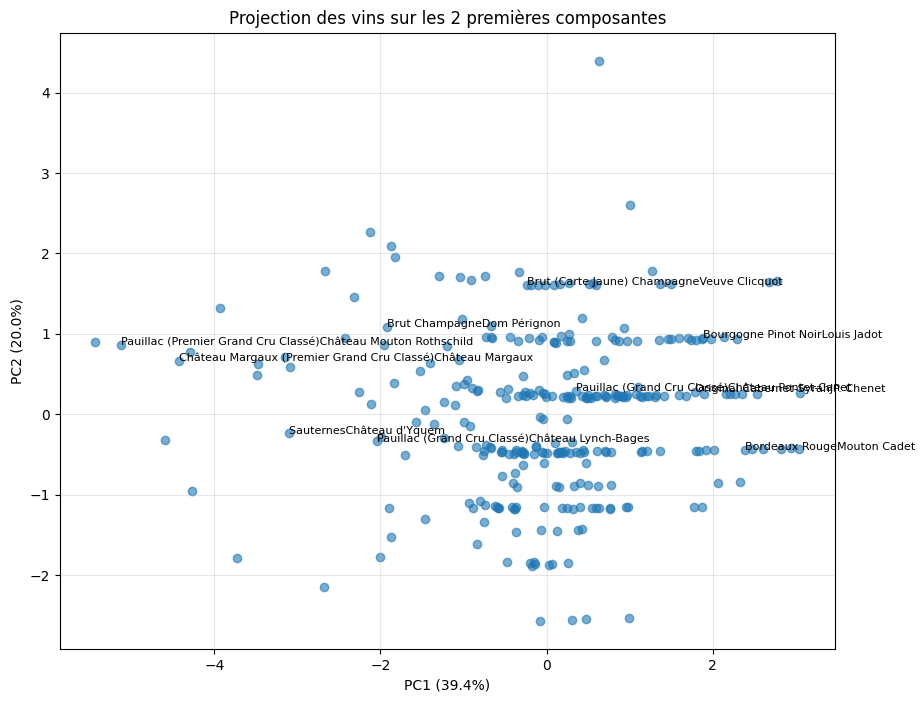

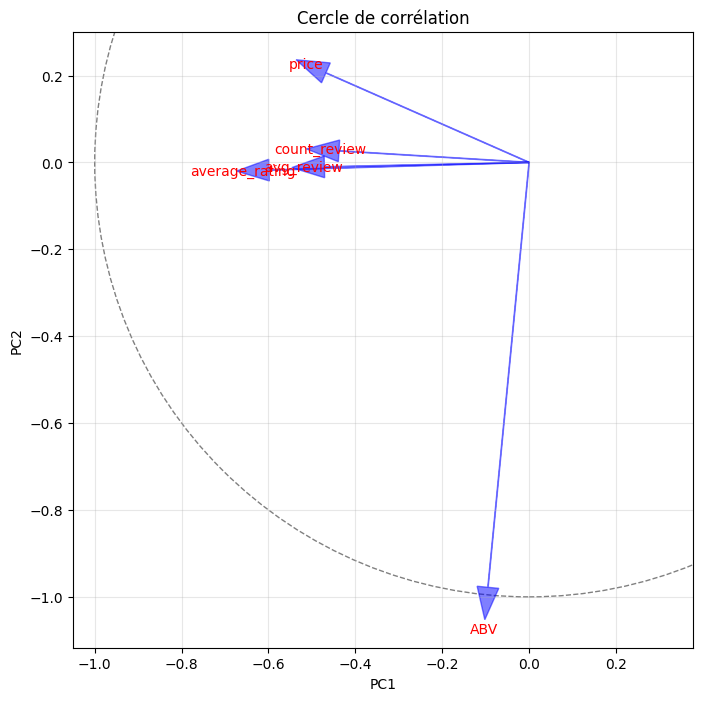


Contribution des variables aux composantes principales:

PC1 (39.4% de variance expliquée):
  ABV: -0.095
  price: -0.468
  average_rating: -0.599
  avg_review: -0.471
  count_review: -0.438

PC2 (20.0% de variance expliquée):
  ABV: -0.978
  price: 0.206
  average_rating: -0.018
  avg_review: -0.010
  count_review: 0.027
--------------------
Nombre de composantes: 1
Erreur de reconstruction (RMSE): 122.5643
Variance expliquée cumulée: 39.45%
--------------------
Nombre de composantes: 2
Erreur de reconstruction (RMSE): 117.8906
Variance expliquée cumulée: 59.47%
--------------------
Nombre de composantes: 3
Erreur de reconstruction (RMSE): 110.4744
Variance expliquée cumulée: 76.61%


In [6]:
import os
from dotenv import load_dotenv
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_connection():
    return mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME")
    )

def load_and_prepare_data():
    """
    Récupère les données depuis la base de données, réalise l'agrégation des reviews et la fusion
    des tables, puis sélectionne les variables numériques pour l'ACP.
    Retourne :
      - data_numeric : DataFrame avec les variables numériques (ABV, price, average_rating, avg_review, count_review)
      - labels : étiquette pour chaque individu (ici, le nom du vin si disponible, sinon l'id)
    """
    conn = get_connection()
    cursor = conn.cursor()

    query_reviews = "SELECT * FROM all_reviews LIMIT 2000;"
    cursor.execute(query_reviews)
    reviews_data = cursor.fetchall()
    reviews_columns = cursor.column_names
    reviews_df = pd.DataFrame(reviews_data, columns=reviews_columns)

    query_descriptifs = "SELECT * FROM descriptifs LIMIT 2000;"
    cursor.execute(query_descriptifs)
    descriptifs_data = cursor.fetchall()
    descriptifs_columns = cursor.column_names
    descriptifs_df = pd.DataFrame(descriptifs_data, columns=descriptifs_columns)

    query_scrap = "SELECT * FROM scrap LIMIT 2000;"
    cursor.execute(query_scrap)
    scrap_data = cursor.fetchall()
    scrap_columns = cursor.column_names
    scrap_df = pd.DataFrame(scrap_data, columns=scrap_columns)

    cursor.close()
    conn.close()

    reviews_agg = reviews_df.groupby('WineID').agg({'Rating': ['mean', 'count']})
    reviews_agg.columns = ['avg_review', 'count_review']
    reviews_agg.reset_index(inplace=True)

    descriptifs_df['idwine'] = descriptifs_df['idwine'].astype(str)
    scrap_df['idwine'] = scrap_df['idwine'].astype(str)
    reviews_agg['WineID'] = reviews_agg['WineID'].astype(str)

    df = pd.merge(descriptifs_df, scrap_df, on='idwine', how='inner')
    df = pd.merge(df, reviews_agg, left_on='idwine', right_on='WineID', how='left')

    features = ['ABV', 'price', 'average_rating', 'avg_review', 'count_review']
    data_numeric = df[features].dropna().astype(float)

    if 'NameWine_WithWinery' in df.columns:
        labels = df.loc[data_numeric.index, 'NameWine_WithWinery']
    else:
        labels = df.loc[data_numeric.index, 'idwine']

    return data_numeric, labels

# -- ACP (calcul manuel) --
def perform_pca_analysis(data):
    """
    Réalise une ACP sur les données (DataFrame) en procédant manuellement :
      - Standardisation
      - Calcul de la matrice de covariance
      - Décomposition en valeurs et vecteurs propres
      - Projection des données
    Retourne un dictionnaire contenant :
      - scaled_data, mean, std, covariance_matrix, eigenvalues, eigenvectors
      - components : vecteurs propres triés
      - transformed : données projetées
      - explained_variance, explained_variance_ratio, cumulative_variance_ratio
      - loadings (ici identiques aux components pour des données standardisées)
      - contributions, cos2, et feature_names
    """
    X = data.values
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof=1)
    X_scaled = (X - mean) / std

    cov_matrix = np.dot(X_scaled.T, X_scaled) / (n_samples - 1)

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    components = eigenvectors.T

    X_transformed = np.dot(X_scaled, eigenvectors)

    total_var = np.sum(eigenvalues)
    explained_variance = eigenvalues
    explained_variance_ratio = eigenvalues / total_var
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    loadings = components
    contributions = loadings ** 2

    cos2 = (X_transformed ** 2) / np.sum(X_transformed ** 2, axis=1, keepdims=True)

    return {
        'scaled_data': X_scaled,
        'mean': mean,
        'std': std,
        'covariance_matrix': cov_matrix,
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'components': components,
        'transformed': X_transformed,
        'explained_variance': explained_variance,
        'explained_variance_ratio': explained_variance_ratio * 100,
        'cumulative_variance_ratio': cumulative_variance_ratio * 100,
        'loadings': loadings,
        'contributions': contributions,
        'cos2': cos2,
        'feature_names': data.columns
    }

# -- Visualisations detaillées : projection et cercle de corrélation --
def plot_detailed_analysis(data, results, labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(results['transformed'][:, 0], results['transformed'][:, 1], alpha=0.6)
    for i, txt in enumerate(labels.iloc[:10]):
        plt.annotate(txt, (results['transformed'][i, 0], results['transformed'][i, 1]), fontsize=8)
    plt.xlabel(f"PC1 ({results['explained_variance_ratio'][0]:.1f}%)")
    plt.ylabel(f"PC2 ({results['explained_variance_ratio'][1]:.1f}%)")
    plt.title('Projection des vins sur les 2 premières composantes')
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 8))
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
    plt.gca().add_artist(circle)
    for i, feature in enumerate(results['feature_names']):
        x = results['components'][0, i]
        y = results['components'][1, i]
        plt.arrow(0, 0, x, y, color='blue', alpha=0.5, head_width=0.05)
        plt.text(x * 1.1, y * 1.1, feature, color='red', ha='center', va='center', fontsize=10)
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Cercle de corrélation")
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    print("\nContribution des variables aux composantes principales :")
    for i in range(2):
        print(f"\nPC{i+1} ({results['explained_variance_ratio'][i]:.1f}% de variance expliquée):")
        for j, feature in enumerate(results['feature_names']):
            print(f"  {feature}: {results['components'][i, j]:.3f}")

# -- Calcul de l'erreur de reconstruction --

def calculate_reconstruction_error(data, results, n_components_range=range(1, 4)):
    """
    Pour chaque nombre de composantes dans n_components_range, reconstruit les données
    et calcule l'erreur de reconstruction (RMSE)
    """
    def reconstruct_from_pca(X_scaled, components, mean, std, n_components):
        X_transformed = np.dot(X_scaled, components.T[:, :n_components])
        X_reconstructed = np.dot(X_transformed, components[:n_components])
        return X_reconstructed * std + mean

    X_scaled = results['scaled_data']
    components = results['components']
    mean = results['mean']
    std = results['std']
    eigenvalues = results['eigenvalues']

    reconstruction_errors = []
    for n_comp in n_components_range:
        X_reconstructed = reconstruct_from_pca(X_scaled, components, mean, std, n_comp)
        mse = np.mean((data.values - X_reconstructed) ** 2)
        rmse = np.sqrt(mse)
        reconstruction_errors.append(rmse)
        variance_explained = np.sum(eigenvalues[:n_comp]) / np.sum(eigenvalues)
        print("--------------------")
        print(f"Nbcomposantes: {n_comp}")
        print(f"Erreur de reconstruction (RMSE): {rmse:.4f}")
        print(f"Variance expliquée : {variance_explained*100:.2f}%")
    return reconstruction_errors
if __name__ == "__main__":
    data, labels = load_and_prepare_data()
    results = perform_pca_analysis(data)
    plot_detailed_analysis(data, results, labels)
    calculate_reconstruction_error(data, results, n_components_range=range(1, 4))
